**Task 1: Loading the data**

Installing pyspark using pip

In [1]:
#pip install pyspark

Importing modules

In [2]:
#importing spark session
from pyspark.sql import SparkSession

#data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#pyspark sql functions
from pyspark.sql import functions as f

#pyspark data processing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

#pyspark data modelling model evaluation models
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Building spark session

In [3]:
spark  = SparkSession.builder.appName('Customer_Churn_Preduction').getOrCreate()
spark

Loading the data

In [4]:
data = spark.read.format('csv').option('inferSchema', True).option('header', True).load('dataset.csv')
data.show(5, truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|7590-VHVEG|Female|No           |Yes    |No        |1     |No          |No phone service|DSL            |No            |Yes         |No              |N

In [5]:
data.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [6]:
data.count(), len(data.columns)

(7043, 21)

**Task 2: Explorative Data Analysis**

* Distribution Analysis
* Correlation Analysis
* Univariate Analysis
* Finding Missing Values

Let's define some lists to store different column names with different data types

In [7]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [8]:
numerical_columns = [name for name, type in data.dtypes if type == 'int' or type == 'double']
categorical_columns = [name for name, type in data.dtypes if type == 'string']

Let's get all the numerical features and store them into pandas dataframe

In [9]:
df_num = data.select(numerical_columns).toPandas()
df_num.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns 

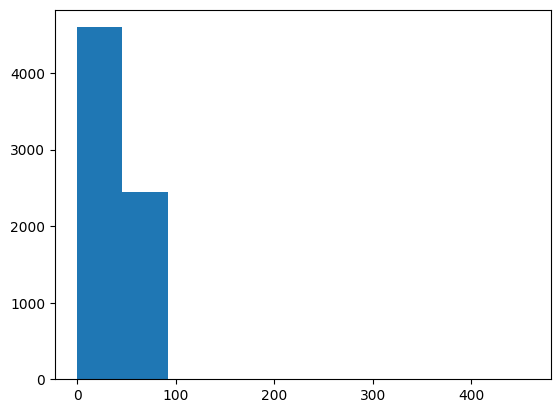

In [10]:
plt.hist(df_num.tenure)
plt.show()

In [11]:
# fig, axes = plt.subplots(1,3, figsize=(15,5))
# for i, num_col in enumerate(df_num.columns):
#     axes[i].hist(df_num[num_col])
#     axes[i].set_title(f'Histogram of {num_col}')
#     axes[i].set_xlabel(num_col)
#     axes[i].set_ylabel('frequency')
# plt.tight_layout()
# plt.show()

C:\Users\shihamf\AppData\Local\Temp\ipykernel_30564\3684380427.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_num.hist(ax=ax, bins=20)


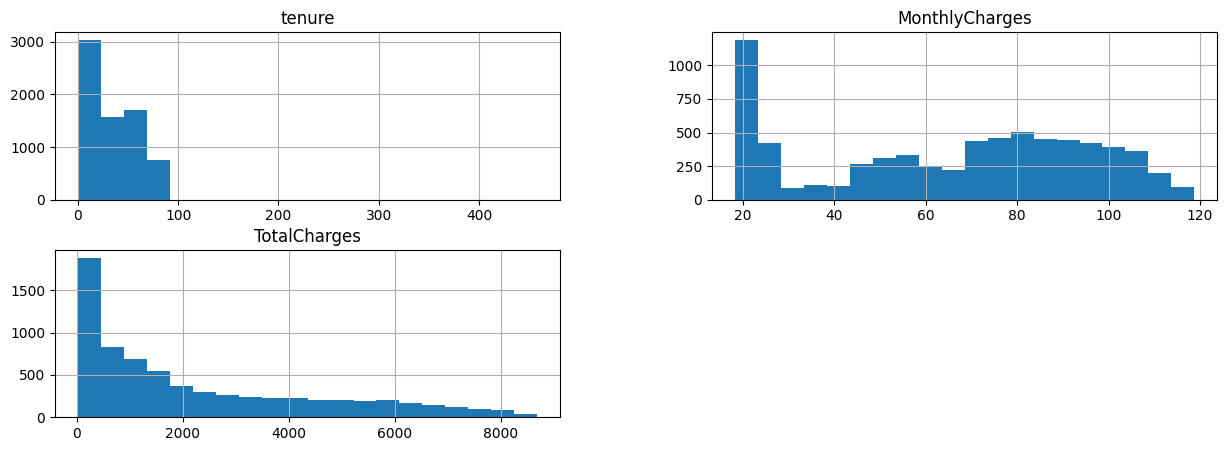

In [12]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
df_num.hist(ax=ax, bins=20)
plt.show()

In [13]:
df_num.tenure.info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: tenure
Non-Null Count  Dtype
--------------  -----
7043 non-null   int32
dtypes: int32(1)
memory usage: 27.6 KB


In [14]:
df_num.tenure.describe()

count    7043.000000
mean       32.435752
std        25.075228
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max       458.000000
Name: tenure, dtype: float64

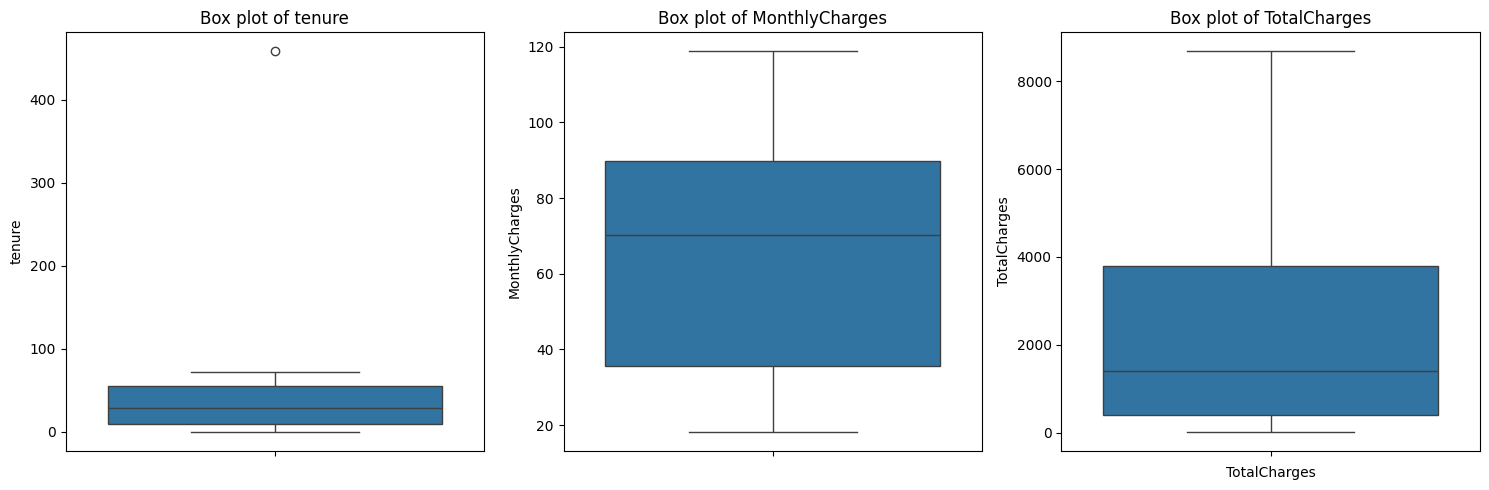

In [15]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

for i, num_col in enumerate(df_num.columns):
    sns.boxplot(df_num[num_col], ax = axes[i])
    axes[i].set_title(f'Box plot of {num_col}')
    plt.xlabel(num_col)
plt.tight_layout()
plt.show()

In [16]:
df_num.TotalCharges.describe

<bound method NDFrame.describe of 0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64>

In [17]:
#Issue_1: There's an outlier in Tenure, we need to get rid of it

Let's generate correlation matrix

In [18]:
df_num.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check unique value count per each categorical variables

In [19]:
categorical_columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [20]:
for cat_col in categorical_columns:
    data.groupby(cat_col).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Let's find number of null values in all of our dataframe columns

In [21]:
for columns in data.columns:
    data.select(
        f.count(
            f.when(
                f.col(columns).isNull(),'Null'
            )
        ).alias(f'Null_{columns}')
    ).show()

+---------------+
|Null_customerID|
+---------------+
|              0|
+---------------+

+-----------+
|Null_gender|
+-----------+
|          0|
+-----------+

+------------------+
|Null_SeniorCitizen|
+------------------+
|                 0|
+------------------+

+------------+
|Null_Partner|
+------------+
|           0|
+------------+

+---------------+
|Null_Dependents|
+---------------+
|              0|
+---------------+

+-----------+
|Null_tenure|
+-----------+
|          0|
+-----------+

+-----------------+
|Null_PhoneService|
+-----------------+
|                0|
+-----------------+

+------------------+
|Null_MultipleLines|
+------------------+
|                 0|
+------------------+

+--------------------+
|Null_InternetService|
+--------------------+
|                   0|
+--------------------+

+-------------------+
|Null_OnlineSecurity|
+-------------------+
|                  0|
+-------------------+

+-----------------+
|Null_OnlineBackup|
+-----------------+


In [22]:
#Issue 2: There are missing values in TotalCharges

**Task 3: Data Preprocessing**

* Handling the missing values
* Removing the outliers

**Handling the missing values**

Let's create a list of column names with missing values

In [23]:
columns_with_missing_values = ['TotalCharges']

Creating imputer

In [24]:
imputer = Imputer(
    inputCols = columns_with_missing_values,
    outputCols = columns_with_missing_values).setStrategy("mean")

Use Imputer to fill the missing values

In [25]:
imputer = imputer.fit(data)
data = imputer.transform(data)

Let's check the missing value counts again

In [26]:
data.select(
        f.count(
            f.when(
                f.col('TotalCharges').isNull(),'Null'
            )
        ).alias('TotalCharges')
    ).show()

+------------+
|TotalCharges|
+------------+
|           0|
+------------+



In [27]:
#There's no missing value now...

**Removing the outliers**

Let's find the customer with tenure higher than 100

In [28]:
data.select('*').filter(f.col('tenure') >= 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's remove the outliers

In [29]:
print('Before removing the outliers: ',data.count())
data = data.filter(f.col('tenure') <= 100)
print('After removing the outliers: ',data.count())

Before removing the outliers:  7043
After removing the outliers:  7042


**Task 4: Feature Preparation**

* Numerical Features
* Categorical Features
* Combining the numerical and categorical features

**Feature Preparation-Numerical Features**

Vector Assembling --> Standard Scalling

**Vector Assembling**

To apply machine learning model we need to combine all the numerical and categorical features into vecotrs. For now let's create a feature vector for numerical columns.

In [30]:
numerical_vector_assembler = VectorAssembler(
    inputCols = numerical_columns,
    outputCol = 'numerical_features_vector'
)
data = numerical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------

In [31]:
scaler = StandardScaler(
    inputCol = 'numerical_features_vector',
    outputCol = 'numerical_features_scaled', withStd = True, withMean = True
)
data = scaler.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------

**Feature Preparation - Categorical Features**

String Indexing --> Vector Assembling
  

**String Indexing**

Need to convert all the string columns to numerical columns


In [32]:
categorical_columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [33]:
categorical_columns_indexed = [name + '_indexed' for name in categorical_columns]

indexer = StringIndexer(
    inputCols = categorical_columns,
    outputCols = categorical_columns_indexed
)

data = indexer.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       Pa

In [34]:
categorical_columns_indexed.remove('customerID_indexed')
categorical_columns_indexed.remove('Churn_indexed')

In [35]:
categorical_columns_indexed

['gender_indexed',
 'SeniorCitizen_indexed',
 'Partner_indexed',
 'Dependents_indexed',
 'PhoneService_indexed',
 'MultipleLines_indexed',
 'InternetService_indexed',
 'OnlineSecurity_indexed',
 'OnlineBackup_indexed',
 'DeviceProtection_indexed',
 'TechSupport_indexed',
 'StreamingTV_indexed',
 'StreamingMovies_indexed',
 'Contract_indexed',
 'PaperlessBilling_indexed',
 'PaymentMethod_indexed']

In [36]:
categorical_vector_assembler = VectorAssembler(
    inputCols = categorical_columns_indexed,
    outputCol = 'categorical_features_vector'
)
data = categorical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contrac

let's combine categorical feature and numerical feature vectors

In [37]:
final_vector_assembler = VectorAssembler(
    inputCols = ['categorical_features_vector', 'numerical_features_scaled'],
    outputCol = 'final_feature_vector')

data = final_vector_assembler.transform(data)

data.select('final_feature_vector','Churn_indexed').show()
            

+--------------------+-------------+
|final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
|(19,[0,5,9,11,12,...|          1.0|
|(19,[3,5,8,11,15,...|          0.0|
|(19,[0,4,5,6,7,14...|          0.0|
|(19,[0,2,5,9,10,1...|          1.0|
|(19,[3,6,7,8,13,1...|          0.0|
|(19,[2,3,6,7,15,1...|          0.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[2,5,9,11,12,...|          0.0|
|(19,[5,8,9,11,12,...|          1.0|
|(19,[7,9,10,11,12...|          0.0|
|[1.0,0.0,1.0,1.0,...|          0.0|
|[1.0,0.0,0.0,0.0,...|          0.0|
|[0.0,0.0,0.0,1.0,...|          0.0|
|(19,[0,2,3,6,9,10...|          1.0|
|(19,[0,8,9,12,16,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



**Task5: Model Training**

* Train and Test data splitting
* Creating a model
* Training a model
* Make initial predictions using the model

In [38]:
train, test = data.randomSplit([0.7, 0.3], seed=100)
test.count()

2112

In [39]:
dt = DecisionTreeClassifier(
    featuresCol = 'final_feature_vector',
    labelCol = 'Churn_indexed',
    maxDepth = 6
)

model = dt.fit(train)

Let's make predictions

In [40]:
prediction_test = model.transform(test)
prediction_test.select(['Churn', 'prediction']).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



**Task6: Model Evaluation**

* Calculating area under the ROC curve for the test set
* Calculating area under the ROC curve for the training set
* Hyper parameter tuning

In [41]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Churn_indexed')
auc_test = evaluator.evaluate(prediction_test,
                              {evaluator.metricName: 'areaUnderROC'})
auc_test
                              

0.7968240892739675

Let's get the AUC test for training set

In [42]:
prediction_train = model.transform(train)
prediction_train.select(['Churn', 'prediction']).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       1.0|
|  Yes|       0.0|
|  Yes|       1.0|
|   No|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



In [43]:
auc_train = evaluator.evaluate(prediction_train,
                              {evaluator.metricName: 'areaUnderROC'})
auc_train
                              

0.797607974377661

**Hyper parameter tuning**

Find the max depth parameter for DT model

In [44]:
def evaluate_dt(model_params):
    test_accuracies = []
    train_accuracies = []
    
    for maxD in model_params:
        #train the model based on the maxD
        
        decision_tree = DecisionTreeClassifier(
            featuresCol = 'final_feature_vector',
            labelCol = 'Churn_indexed',
            maxDepth = maxD
        )

        dtmodel = decision_tree.fit(train)
        
        #calculating the testing error
        prediction_test = dtmodel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol = 'Churn_indexed')
        auc_test = evaluator.evaluate(prediction_test,
                                      {evaluator.metricName: 'areaUnderROC'})
        #recording the accuracy
        test_accuracies.append(auc_test)

        #calculating the training error
        prediction_train = dtmodel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol = 'Churn_indexed')
        auc_train = evaluator.evaluate(prediction_train,
                                      {evaluator.metricName: 'areaUnderROC'})
        #recording the accuracy
        train_accuracies.append(auc_train)

    return test_accuracies, train_accuracies
        

In [45]:
max_depth = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_accs, train_accs = evaluate_dt(max_depth)

print(train_accs)
print(test_accs)

[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.797607974377661, 0.7600331160893413, 0.7616399322585649, 0.7851198149534798, 0.82591977092655, 0.8633625692715379, 0.8899907318309699, 0.9236516335825413, 0.9402616892332477, 0.9521037242780167, 0.9662424766482165, 0.9763120733848871, 0.9807472862567603, 0.9853808496196841, 0.9883361989750398]
[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968240892739675, 0.7464077658395512, 0.7486976928866473, 0.7390283218461648, 0.7568262227463716, 0.7717528253693575, 0.770466222983424, 0.7493673661690539, 0.7371905724224987, 0.7208594338001293, 0.7102797812005524, 0.704298946894316, 0.7036452746549405, 0.6956814962753128, 0.6895714683623821]


Visualize the results

In [65]:
import pandas as pd

df = pd.DataFrame()
df['max_depth'] = max_depth
df['train_accs'] = train_accs
df['test_accs'] = test_accs

df.head()

,max_depth,train_accs,test_accs
0,2,0.773771,0.791874
1,3,0.772111,0.767823
2,4,0.673202,0.693851
3,5,0.564740,0.566494
4,6,0.797608,0.796824


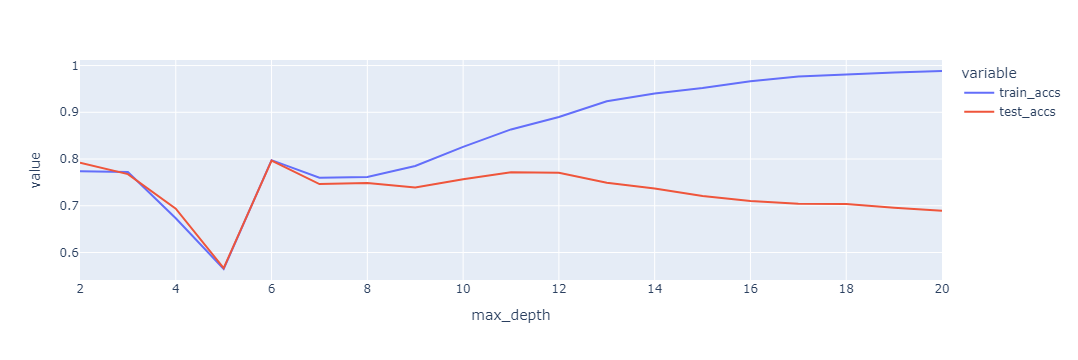

In [67]:
#Plotting the two lines
px.line(df, x='max_depth', y = ['train_accs', 'test_accs'])

In [64]:
#optimum max_depth based on visualozation is 6
#after than there's overfitting and before that there's under fitting
#Go back and change the max depth into 6

**Task 7: Model Deployment**

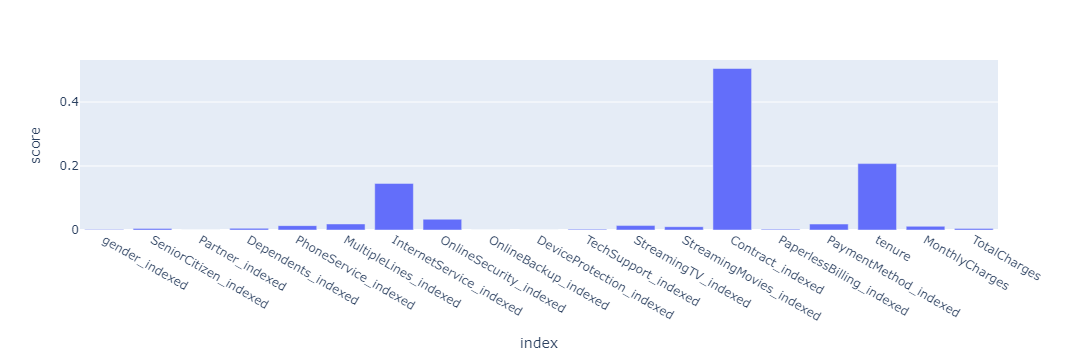

In [69]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(
    scores,
    columns = ['score'],
    index = categorical_columns_indexed + numerical_columns)
px.bar(df, x=df.index', y='score')

Let's create a bra chart to visualize the customer churn per contract type

In [82]:
df_contract = data.groupBy(
    ['Contract','Churn']
).count().toPandas()

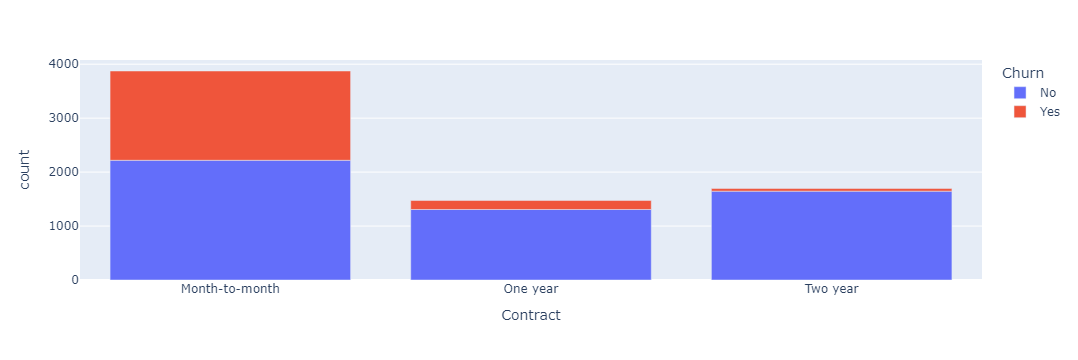

In [85]:
px.bar(df_contract, x='Contract', y='count', color='Churn')